In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 375443 images
Dataset type val label type: species


Loaded 48562 images
Dataset type test label type: species


 - Min class count:  976
Loaded 20496 images
Dataset type test label type: species


 - Min class count:  976
Loaded 0 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 qsi4bt99


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-qsi4bt99:best, 58.48MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:9.1


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                        | 0/2934 [00:00<?, ?it/s]

  0%|                                                                                                                                                | 1/2934 [00:01<54:40,  1.12s/it]

  0%|▎                                                                                                                                               | 6/2934 [00:01<07:44,  6.30it/s]

  0%|▌                                                                                                                                              | 11/2934 [00:01<04:02, 12.03it/s]

  1%|▊                                                                                                                                              | 16/2934 [00:01<02:44, 17.76it/s]

  1%|█                                                                                                                                              | 21/2934 [00:01<02:05, 23.12it/s]

  1%|█▎                                                                                                                                             | 26/2934 [00:01<01:44, 27.91it/s]

  1%|█▌                                                                                                                                             | 31/2934 [00:01<01:31, 31.90it/s]

  1%|█▊                                                                                                                                             | 36/2934 [00:01<01:22, 35.11it/s]

  1%|█▉                                                                                                                                             | 41/2934 [00:02<01:16, 37.65it/s]

  2%|██▏                                                                                                                                            | 46/2934 [00:02<01:13, 39.51it/s]

  2%|██▍                                                                                                                                            | 51/2934 [00:02<01:10, 40.88it/s]

  2%|██▋                                                                                                                                            | 56/2934 [00:02<01:08, 41.88it/s]

  2%|██▉                                                                                                                                            | 61/2934 [00:02<01:07, 42.66it/s]

  2%|███▏                                                                                                                                           | 66/2934 [00:02<01:06, 43.15it/s]

  2%|███▍                                                                                                                                           | 71/2934 [00:02<01:05, 43.52it/s]

  3%|███▋                                                                                                                                           | 76/2934 [00:02<01:05, 43.83it/s]

  3%|███▉                                                                                                                                           | 81/2934 [00:02<01:04, 43.99it/s]

  3%|████▏                                                                                                                                          | 86/2934 [00:03<01:04, 44.10it/s]

  3%|████▍                                                                                                                                          | 91/2934 [00:03<01:04, 44.18it/s]

  3%|████▋                                                                                                                                          | 96/2934 [00:03<01:04, 44.29it/s]

  3%|████▉                                                                                                                                         | 101/2934 [00:03<01:03, 44.31it/s]

  4%|█████▏                                                                                                                                        | 106/2934 [00:03<01:03, 44.32it/s]

  4%|█████▎                                                                                                                                        | 111/2934 [00:03<01:03, 44.42it/s]

  4%|█████▌                                                                                                                                        | 116/2934 [00:03<01:03, 44.41it/s]

  4%|█████▊                                                                                                                                        | 121/2934 [00:03<01:03, 44.37it/s]

  4%|██████                                                                                                                                        | 126/2934 [00:03<01:03, 44.38it/s]

  4%|██████▎                                                                                                                                       | 131/2934 [00:04<01:03, 44.43it/s]

  5%|██████▌                                                                                                                                       | 136/2934 [00:04<01:02, 44.41it/s]

  5%|██████▊                                                                                                                                       | 141/2934 [00:04<01:02, 44.39it/s]

  5%|███████                                                                                                                                       | 146/2934 [00:04<01:02, 44.46it/s]

  5%|███████▎                                                                                                                                      | 151/2934 [00:04<01:02, 44.43it/s]

  5%|███████▌                                                                                                                                      | 156/2934 [00:04<01:02, 44.37it/s]

  5%|███████▊                                                                                                                                      | 161/2934 [00:04<01:02, 44.38it/s]

  6%|████████                                                                                                                                      | 166/2934 [00:04<01:02, 44.41it/s]

  6%|████████▎                                                                                                                                     | 171/2934 [00:04<01:02, 44.42it/s]

  6%|████████▌                                                                                                                                     | 176/2934 [00:05<01:02, 44.40it/s]

  6%|████████▊                                                                                                                                     | 181/2934 [00:05<01:01, 44.47it/s]

  6%|█████████                                                                                                                                     | 186/2934 [00:05<01:01, 44.43it/s]

  7%|█████████▏                                                                                                                                    | 191/2934 [00:05<01:01, 44.43it/s]

  7%|█████████▍                                                                                                                                    | 196/2934 [00:05<01:01, 44.41it/s]

  7%|█████████▋                                                                                                                                    | 201/2934 [00:05<01:01, 44.46it/s]

  7%|█████████▉                                                                                                                                    | 206/2934 [00:05<01:01, 44.42it/s]

  7%|██████████▏                                                                                                                                   | 211/2934 [00:05<01:01, 44.43it/s]

  7%|██████████▍                                                                                                                                   | 216/2934 [00:05<01:01, 44.49it/s]

  8%|██████████▋                                                                                                                                   | 221/2934 [00:06<01:01, 44.45it/s]

  8%|██████████▉                                                                                                                                   | 226/2934 [00:06<01:00, 44.41it/s]

  8%|███████████▏                                                                                                                                  | 231/2934 [00:06<01:00, 44.40it/s]

  8%|███████████▍                                                                                                                                  | 236/2934 [00:06<01:00, 44.45it/s]

  8%|███████████▋                                                                                                                                  | 241/2934 [00:06<01:00, 44.39it/s]

  8%|███████████▉                                                                                                                                  | 246/2934 [00:06<01:00, 44.34it/s]

  9%|████████████▏                                                                                                                                 | 251/2934 [00:06<01:00, 44.34it/s]

  9%|████████████▍                                                                                                                                 | 256/2934 [00:06<01:00, 44.34it/s]

  9%|████████████▋                                                                                                                                 | 261/2934 [00:06<01:00, 44.42it/s]

  9%|████████████▊                                                                                                                                 | 266/2934 [00:07<01:00, 44.40it/s]

  9%|█████████████                                                                                                                                 | 271/2934 [00:07<00:59, 44.40it/s]

  9%|█████████████▎                                                                                                                                | 276/2934 [00:07<00:59, 44.39it/s]

 10%|█████████████▌                                                                                                                                | 281/2934 [00:07<00:59, 44.44it/s]

 10%|█████████████▊                                                                                                                                | 286/2934 [00:07<00:59, 44.41it/s]

 10%|██████████████                                                                                                                                | 291/2934 [00:07<00:59, 44.41it/s]

 10%|██████████████▎                                                                                                                               | 296/2934 [00:07<00:59, 44.48it/s]

 10%|██████████████▌                                                                                                                               | 301/2934 [00:07<00:59, 44.44it/s]

 10%|██████████████▊                                                                                                                               | 306/2934 [00:07<00:59, 44.42it/s]

 11%|███████████████                                                                                                                               | 311/2934 [00:08<00:59, 44.42it/s]

 11%|███████████████▎                                                                                                                              | 316/2934 [00:08<00:58, 44.48it/s]

 11%|███████████████▌                                                                                                                              | 321/2934 [00:08<00:58, 44.43it/s]

 11%|███████████████▊                                                                                                                              | 326/2934 [00:08<00:58, 44.42it/s]

 11%|████████████████                                                                                                                              | 331/2934 [00:08<00:58, 44.42it/s]

 11%|████████████████▎                                                                                                                             | 336/2934 [00:08<00:58, 44.48it/s]

 12%|████████████████▌                                                                                                                             | 341/2934 [00:08<00:58, 44.45it/s]

 12%|████████████████▋                                                                                                                             | 346/2934 [00:08<00:58, 44.43it/s]

 12%|████████████████▉                                                                                                                             | 351/2934 [00:09<00:58, 44.49it/s]

 12%|█████████████████▏                                                                                                                            | 356/2934 [00:09<00:58, 44.43it/s]

 12%|█████████████████▍                                                                                                                            | 361/2934 [00:09<00:57, 44.39it/s]

 12%|█████████████████▋                                                                                                                            | 366/2934 [00:09<00:57, 44.39it/s]

 13%|█████████████████▉                                                                                                                            | 371/2934 [00:09<00:57, 44.46it/s]

 13%|██████████████████▏                                                                                                                           | 376/2934 [00:09<00:57, 44.43it/s]

 13%|██████████████████▍                                                                                                                           | 381/2934 [00:09<00:57, 44.41it/s]

 13%|██████████████████▋                                                                                                                           | 386/2934 [00:09<00:57, 44.43it/s]

 13%|██████████████████▉                                                                                                                           | 391/2934 [00:09<00:57, 44.37it/s]

 13%|███████████████████▏                                                                                                                          | 396/2934 [00:10<00:57, 44.30it/s]

 14%|███████████████████▍                                                                                                                          | 401/2934 [00:10<00:57, 44.33it/s]

 14%|███████████████████▋                                                                                                                          | 406/2934 [00:10<00:57, 44.31it/s]

 14%|███████████████████▉                                                                                                                          | 411/2934 [00:10<00:56, 44.41it/s]

 14%|████████████████████▏                                                                                                                         | 416/2934 [00:10<00:56, 44.41it/s]

 14%|████████████████████▍                                                                                                                         | 421/2934 [00:10<00:56, 44.42it/s]

 15%|████████████████████▌                                                                                                                         | 426/2934 [00:10<00:56, 44.47it/s]

 15%|████████████████████▊                                                                                                                         | 431/2934 [00:10<00:56, 44.42it/s]

 15%|█████████████████████                                                                                                                         | 436/2934 [00:10<00:56, 44.40it/s]

 15%|█████████████████████▎                                                                                                                        | 441/2934 [00:11<00:56, 44.47it/s]

 15%|█████████████████████▌                                                                                                                        | 446/2934 [00:11<00:55, 44.44it/s]

 15%|█████████████████████▊                                                                                                                        | 451/2934 [00:11<00:55, 44.42it/s]

 16%|██████████████████████                                                                                                                        | 456/2934 [00:11<00:55, 44.35it/s]

 16%|██████████████████████▎                                                                                                                       | 461/2934 [00:11<00:55, 44.33it/s]

 16%|██████████████████████▌                                                                                                                       | 466/2934 [00:11<00:55, 44.22it/s]

 16%|██████████████████████▊                                                                                                                       | 471/2934 [00:11<00:55, 44.16it/s]

 16%|███████████████████████                                                                                                                       | 476/2934 [00:11<00:55, 44.32it/s]

 16%|███████████████████████▎                                                                                                                      | 481/2934 [00:11<00:55, 44.31it/s]

 17%|███████████████████████▌                                                                                                                      | 486/2934 [00:12<00:55, 44.33it/s]

 17%|███████████████████████▊                                                                                                                      | 491/2934 [00:12<00:55, 44.36it/s]

 17%|████████████████████████                                                                                                                      | 496/2934 [00:12<00:54, 44.42it/s]

 17%|████████████████████████▏                                                                                                                     | 501/2934 [00:12<00:54, 44.39it/s]

 17%|████████████████████████▍                                                                                                                     | 506/2934 [00:12<00:54, 44.37it/s]

 17%|████████████████████████▋                                                                                                                     | 511/2934 [00:12<00:54, 44.36it/s]

 18%|████████████████████████▉                                                                                                                     | 516/2934 [00:12<00:54, 44.42it/s]

 18%|█████████████████████████▏                                                                                                                    | 521/2934 [00:12<00:54, 44.48it/s]

 18%|█████████████████████████▍                                                                                                                    | 526/2934 [00:12<00:54, 44.44it/s]

 18%|█████████████████████████▋                                                                                                                    | 531/2934 [00:13<00:54, 44.41it/s]

 18%|█████████████████████████▉                                                                                                                    | 536/2934 [00:13<00:53, 44.48it/s]

 18%|██████████████████████████▏                                                                                                                   | 541/2934 [00:13<00:53, 44.42it/s]

 19%|██████████████████████████▍                                                                                                                   | 546/2934 [00:13<00:53, 44.40it/s]

 19%|██████████████████████████▋                                                                                                                   | 551/2934 [00:13<00:53, 44.41it/s]

 19%|██████████████████████████▉                                                                                                                   | 556/2934 [00:13<00:53, 44.46it/s]

 19%|███████████████████████████▏                                                                                                                  | 561/2934 [00:13<00:53, 44.37it/s]

 19%|███████████████████████████▍                                                                                                                  | 566/2934 [00:13<00:53, 44.35it/s]

 19%|███████████████████████████▋                                                                                                                  | 571/2934 [00:13<00:53, 44.43it/s]

 20%|███████████████████████████▉                                                                                                                  | 576/2934 [00:14<00:53, 44.30it/s]

 20%|████████████████████████████                                                                                                                  | 581/2934 [00:14<00:53, 44.38it/s]

 20%|████████████████████████████▎                                                                                                                 | 586/2934 [00:14<00:52, 44.38it/s]

 20%|████████████████████████████▌                                                                                                                 | 591/2934 [00:14<00:52, 44.46it/s]

 20%|████████████████████████████▊                                                                                                                 | 596/2934 [00:14<00:52, 44.42it/s]

 20%|█████████████████████████████                                                                                                                 | 601/2934 [00:14<00:52, 44.41it/s]

 21%|█████████████████████████████▎                                                                                                                | 606/2934 [00:14<00:52, 44.41it/s]

 21%|█████████████████████████████▌                                                                                                                | 611/2934 [00:14<00:52, 44.47it/s]

 21%|█████████████████████████████▊                                                                                                                | 616/2934 [00:14<00:52, 44.44it/s]

 21%|██████████████████████████████                                                                                                                | 621/2934 [00:15<00:52, 44.42it/s]

 21%|██████████████████████████████▎                                                                                                               | 626/2934 [00:15<00:51, 44.47it/s]

 22%|██████████████████████████████▌                                                                                                               | 631/2934 [00:15<00:51, 44.43it/s]

 22%|██████████████████████████████▊                                                                                                               | 636/2934 [00:15<00:51, 44.40it/s]

 22%|███████████████████████████████                                                                                                               | 641/2934 [00:15<00:51, 44.41it/s]

 22%|███████████████████████████████▎                                                                                                              | 646/2934 [00:15<00:51, 44.30it/s]

 22%|███████████████████████████████▌                                                                                                              | 651/2934 [00:15<00:51, 44.06it/s]

 22%|███████████████████████████████▋                                                                                                              | 656/2934 [00:15<00:51, 43.91it/s]

 23%|███████████████████████████████▉                                                                                                              | 661/2934 [00:15<00:51, 43.80it/s]

 23%|████████████████████████████████▏                                                                                                             | 666/2934 [00:16<00:51, 43.71it/s]

 23%|████████████████████████████████▍                                                                                                             | 671/2934 [00:16<00:51, 43.67it/s]

 23%|████████████████████████████████▋                                                                                                             | 676/2934 [00:16<00:51, 43.66it/s]

 23%|████████████████████████████████▉                                                                                                             | 681/2934 [00:16<00:51, 43.61it/s]

 23%|█████████████████████████████████▏                                                                                                            | 686/2934 [00:16<00:51, 43.61it/s]

 24%|█████████████████████████████████▍                                                                                                            | 691/2934 [00:16<00:51, 43.63it/s]

 24%|█████████████████████████████████▋                                                                                                            | 696/2934 [00:16<00:51, 43.62it/s]

 24%|█████████████████████████████████▉                                                                                                            | 701/2934 [00:16<00:51, 43.60it/s]

 24%|██████████████████████████████████▏                                                                                                           | 706/2934 [00:17<00:51, 43.60it/s]

 24%|██████████████████████████████████▍                                                                                                           | 711/2934 [00:17<00:50, 43.61it/s]

 24%|██████████████████████████████████▋                                                                                                           | 716/2934 [00:17<00:50, 43.57it/s]

 25%|██████████████████████████████████▉                                                                                                           | 721/2934 [00:17<00:50, 43.55it/s]

 25%|███████████████████████████████████▏                                                                                                          | 726/2934 [00:17<00:50, 43.53it/s]

 25%|███████████████████████████████████▍                                                                                                          | 731/2934 [00:17<00:50, 43.50it/s]

 25%|███████████████████████████████████▌                                                                                                          | 736/2934 [00:17<00:50, 43.51it/s]

 25%|███████████████████████████████████▊                                                                                                          | 741/2934 [00:17<00:50, 43.54it/s]

 25%|████████████████████████████████████                                                                                                          | 746/2934 [00:17<00:50, 43.56it/s]

 26%|████████████████████████████████████▎                                                                                                         | 751/2934 [00:18<00:50, 43.57it/s]

 26%|████████████████████████████████████▌                                                                                                         | 756/2934 [00:18<00:49, 43.58it/s]

 26%|████████████████████████████████████▊                                                                                                         | 761/2934 [00:18<00:49, 43.59it/s]

 26%|█████████████████████████████████████                                                                                                         | 766/2934 [00:18<00:49, 43.58it/s]

 26%|█████████████████████████████████████▎                                                                                                        | 771/2934 [00:18<00:49, 43.57it/s]

 26%|█████████████████████████████████████▌                                                                                                        | 776/2934 [00:18<00:49, 43.59it/s]

 27%|█████████████████████████████████████▊                                                                                                        | 781/2934 [00:18<00:49, 43.60it/s]

 27%|██████████████████████████████████████                                                                                                        | 786/2934 [00:18<00:49, 43.60it/s]

 27%|██████████████████████████████████████▎                                                                                                       | 791/2934 [00:18<00:49, 43.59it/s]

 27%|██████████████████████████████████████▌                                                                                                       | 796/2934 [00:19<00:49, 43.59it/s]

 27%|██████████████████████████████████████▊                                                                                                       | 801/2934 [00:19<00:48, 43.61it/s]

 27%|███████████████████████████████████████                                                                                                       | 806/2934 [00:19<00:48, 43.60it/s]

 28%|███████████████████████████████████████▎                                                                                                      | 811/2934 [00:19<00:48, 43.60it/s]

 28%|███████████████████████████████████████▍                                                                                                      | 816/2934 [00:19<00:48, 43.61it/s]

 28%|███████████████████████████████████████▋                                                                                                      | 821/2934 [00:19<00:48, 43.55it/s]

 28%|███████████████████████████████████████▉                                                                                                      | 826/2934 [00:19<00:48, 43.57it/s]

 28%|████████████████████████████████████████▏                                                                                                     | 831/2934 [00:19<00:48, 43.57it/s]

 28%|████████████████████████████████████████▍                                                                                                     | 836/2934 [00:20<00:48, 43.59it/s]

 29%|████████████████████████████████████████▋                                                                                                     | 841/2934 [00:20<00:48, 43.58it/s]

 29%|████████████████████████████████████████▉                                                                                                     | 846/2934 [00:20<00:47, 43.59it/s]

 29%|█████████████████████████████████████████▏                                                                                                    | 851/2934 [00:20<00:47, 43.60it/s]

 29%|█████████████████████████████████████████▍                                                                                                    | 856/2934 [00:20<00:47, 43.60it/s]

 29%|█████████████████████████████████████████▋                                                                                                    | 861/2934 [00:20<00:47, 43.60it/s]

 30%|█████████████████████████████████████████▉                                                                                                    | 866/2934 [00:20<00:47, 43.60it/s]

 30%|██████████████████████████████████████████▏                                                                                                   | 871/2934 [00:20<00:47, 43.56it/s]

 30%|██████████████████████████████████████████▍                                                                                                   | 876/2934 [00:20<00:47, 43.52it/s]

 30%|██████████████████████████████████████████▋                                                                                                   | 881/2934 [00:21<00:47, 43.47it/s]

 30%|██████████████████████████████████████████▉                                                                                                   | 886/2934 [00:21<00:47, 43.45it/s]

 30%|███████████████████████████████████████████                                                                                                   | 891/2934 [00:21<00:46, 43.48it/s]

 31%|███████████████████████████████████████████▎                                                                                                  | 896/2934 [00:21<00:46, 43.52it/s]

 31%|███████████████████████████████████████████▌                                                                                                  | 901/2934 [00:21<00:46, 43.54it/s]

 31%|███████████████████████████████████████████▊                                                                                                  | 906/2934 [00:21<00:46, 43.56it/s]

 31%|████████████████████████████████████████████                                                                                                  | 911/2934 [00:21<00:46, 43.57it/s]

 31%|████████████████████████████████████████████▎                                                                                                 | 916/2934 [00:21<00:46, 43.58it/s]

 31%|████████████████████████████████████████████▌                                                                                                 | 921/2934 [00:21<00:46, 43.54it/s]

 32%|████████████████████████████████████████████▊                                                                                                 | 926/2934 [00:22<00:46, 43.54it/s]

 32%|█████████████████████████████████████████████                                                                                                 | 931/2934 [00:22<00:45, 43.56it/s]

 32%|█████████████████████████████████████████████▎                                                                                                | 936/2934 [00:22<00:45, 43.58it/s]

 32%|█████████████████████████████████████████████▌                                                                                                | 941/2934 [00:22<00:45, 43.58it/s]

 32%|█████████████████████████████████████████████▊                                                                                                | 946/2934 [00:22<00:45, 43.58it/s]

 32%|██████████████████████████████████████████████                                                                                                | 951/2934 [00:22<00:45, 43.59it/s]

 33%|██████████████████████████████████████████████▎                                                                                               | 956/2934 [00:22<00:45, 43.58it/s]

 33%|██████████████████████████████████████████████▌                                                                                               | 961/2934 [00:22<00:45, 43.57it/s]

 33%|██████████████████████████████████████████████▊                                                                                               | 966/2934 [00:22<00:45, 43.57it/s]

 33%|██████████████████████████████████████████████▉                                                                                               | 971/2934 [00:23<00:45, 43.58it/s]

 33%|███████████████████████████████████████████████▏                                                                                              | 976/2934 [00:23<00:44, 43.59it/s]

 33%|███████████████████████████████████████████████▍                                                                                              | 981/2934 [00:23<00:44, 43.60it/s]

 34%|███████████████████████████████████████████████▋                                                                                              | 986/2934 [00:23<00:44, 43.60it/s]

 34%|███████████████████████████████████████████████▉                                                                                              | 991/2934 [00:23<00:44, 43.60it/s]

 34%|████████████████████████████████████████████████▏                                                                                             | 996/2934 [00:23<00:44, 43.62it/s]

 34%|████████████████████████████████████████████████                                                                                             | 1001/2934 [00:23<00:44, 43.60it/s]

 34%|████████████████████████████████████████████████▎                                                                                            | 1006/2934 [00:23<00:44, 43.58it/s]

 34%|████████████████████████████████████████████████▌                                                                                            | 1011/2934 [00:24<00:44, 43.60it/s]

 35%|████████████████████████████████████████████████▊                                                                                            | 1016/2934 [00:24<00:43, 43.60it/s]

 35%|█████████████████████████████████████████████████                                                                                            | 1021/2934 [00:24<00:43, 43.58it/s]

 35%|█████████████████████████████████████████████████▎                                                                                           | 1026/2934 [00:24<00:43, 43.54it/s]

 35%|█████████████████████████████████████████████████▌                                                                                           | 1031/2934 [00:24<00:43, 43.52it/s]

 35%|█████████████████████████████████████████████████▊                                                                                           | 1036/2934 [00:24<00:43, 43.49it/s]

 35%|██████████████████████████████████████████████████                                                                                           | 1041/2934 [00:24<00:43, 43.41it/s]

 36%|██████████████████████████████████████████████████▎                                                                                          | 1046/2934 [00:24<00:43, 43.43it/s]

 36%|██████████████████████████████████████████████████▌                                                                                          | 1051/2934 [00:24<00:43, 43.47it/s]

 36%|██████████████████████████████████████████████████▋                                                                                          | 1056/2934 [00:25<00:43, 43.45it/s]

 36%|██████████████████████████████████████████████████▉                                                                                          | 1061/2934 [00:25<00:43, 43.43it/s]

 36%|███████████████████████████████████████████████████▏                                                                                         | 1066/2934 [00:25<00:42, 43.46it/s]

 37%|███████████████████████████████████████████████████▍                                                                                         | 1071/2934 [00:25<00:42, 43.50it/s]

 37%|███████████████████████████████████████████████████▋                                                                                         | 1076/2934 [00:25<00:42, 43.54it/s]

 37%|███████████████████████████████████████████████████▉                                                                                         | 1081/2934 [00:25<00:42, 43.56it/s]

 37%|████████████████████████████████████████████████████▏                                                                                        | 1086/2934 [00:25<00:42, 43.53it/s]

 37%|████████████████████████████████████████████████████▍                                                                                        | 1091/2934 [00:25<00:42, 43.55it/s]

 37%|████████████████████████████████████████████████████▋                                                                                        | 1096/2934 [00:25<00:42, 43.53it/s]

 38%|████████████████████████████████████████████████████▉                                                                                        | 1101/2934 [00:26<00:42, 43.52it/s]

 38%|█████████████████████████████████████████████████████▏                                                                                       | 1106/2934 [00:26<00:42, 43.50it/s]

 38%|█████████████████████████████████████████████████████▍                                                                                       | 1111/2934 [00:26<00:41, 43.51it/s]

 38%|█████████████████████████████████████████████████████▋                                                                                       | 1116/2934 [00:26<00:41, 43.51it/s]

 38%|█████████████████████████████████████████████████████▊                                                                                       | 1121/2934 [00:26<00:41, 43.55it/s]

 38%|██████████████████████████████████████████████████████                                                                                       | 1126/2934 [00:26<00:41, 43.52it/s]

 39%|██████████████████████████████████████████████████████▎                                                                                      | 1131/2934 [00:26<00:41, 43.53it/s]

 39%|██████████████████████████████████████████████████████▌                                                                                      | 1136/2934 [00:26<00:41, 43.54it/s]

 39%|██████████████████████████████████████████████████████▊                                                                                      | 1141/2934 [00:27<00:41, 43.54it/s]

 39%|███████████████████████████████████████████████████████                                                                                      | 1146/2934 [00:27<00:41, 43.53it/s]

 39%|███████████████████████████████████████████████████████▎                                                                                     | 1151/2934 [00:27<00:40, 43.53it/s]

 39%|███████████████████████████████████████████████████████▌                                                                                     | 1156/2934 [00:27<00:40, 43.54it/s]

 40%|███████████████████████████████████████████████████████▊                                                                                     | 1161/2934 [00:27<00:40, 43.51it/s]

 40%|████████████████████████████████████████████████████████                                                                                     | 1166/2934 [00:27<00:40, 43.48it/s]

 40%|████████████████████████████████████████████████████████▎                                                                                    | 1171/2934 [00:27<00:40, 43.39it/s]

 40%|████████████████████████████████████████████████████████▌                                                                                    | 1176/2934 [00:27<00:40, 43.39it/s]

 40%|████████████████████████████████████████████████████████▊                                                                                    | 1181/2934 [00:27<00:40, 43.42it/s]

 40%|████████████████████████████████████████████████████████▉                                                                                    | 1186/2934 [00:28<00:40, 43.46it/s]

 41%|█████████████████████████████████████████████████████████▏                                                                                   | 1191/2934 [00:28<00:40, 43.48it/s]

 41%|█████████████████████████████████████████████████████████▍                                                                                   | 1196/2934 [00:28<00:39, 43.49it/s]

 41%|█████████████████████████████████████████████████████████▋                                                                                   | 1201/2934 [00:28<00:39, 43.49it/s]

 41%|█████████████████████████████████████████████████████████▉                                                                                   | 1206/2934 [00:28<00:39, 43.52it/s]

 41%|██████████████████████████████████████████████████████████▏                                                                                  | 1211/2934 [00:28<00:39, 43.54it/s]

 41%|██████████████████████████████████████████████████████████▍                                                                                  | 1216/2934 [00:28<00:39, 43.53it/s]

 42%|██████████████████████████████████████████████████████████▋                                                                                  | 1221/2934 [00:28<00:39, 43.51it/s]

 42%|██████████████████████████████████████████████████████████▉                                                                                  | 1226/2934 [00:28<00:39, 43.50it/s]

 42%|███████████████████████████████████████████████████████████▏                                                                                 | 1231/2934 [00:29<00:39, 43.51it/s]

 42%|███████████████████████████████████████████████████████████▍                                                                                 | 1236/2934 [00:29<00:38, 43.54it/s]

 42%|███████████████████████████████████████████████████████████▋                                                                                 | 1241/2934 [00:29<00:38, 43.56it/s]

 42%|███████████████████████████████████████████████████████████▉                                                                                 | 1246/2934 [00:29<00:38, 43.53it/s]

 43%|████████████████████████████████████████████████████████████                                                                                 | 1251/2934 [00:29<00:38, 43.54it/s]

 43%|████████████████████████████████████████████████████████████▎                                                                                | 1256/2934 [00:29<00:38, 43.52it/s]

 43%|████████████████████████████████████████████████████████████▌                                                                                | 1261/2934 [00:29<00:38, 43.52it/s]

 43%|████████████████████████████████████████████████████████████▊                                                                                | 1266/2934 [00:29<00:38, 43.50it/s]

 43%|█████████████████████████████████████████████████████████████                                                                                | 1271/2934 [00:30<00:38, 43.50it/s]

 43%|█████████████████████████████████████████████████████████████▎                                                                               | 1276/2934 [00:30<00:38, 43.51it/s]

 44%|█████████████████████████████████████████████████████████████▌                                                                               | 1281/2934 [00:30<00:37, 43.53it/s]

 44%|█████████████████████████████████████████████████████████████▊                                                                               | 1286/2934 [00:30<00:37, 43.53it/s]

 44%|██████████████████████████████████████████████████████████████                                                                               | 1291/2934 [00:30<00:37, 43.51it/s]

 44%|██████████████████████████████████████████████████████████████▎                                                                              | 1296/2934 [00:30<00:37, 43.51it/s]

 44%|██████████████████████████████████████████████████████████████▌                                                                              | 1301/2934 [00:30<00:37, 43.52it/s]

 45%|██████████████████████████████████████████████████████████████▊                                                                              | 1306/2934 [00:30<00:37, 43.51it/s]

 45%|███████████████████████████████████████████████████████████████                                                                              | 1311/2934 [00:30<00:37, 43.42it/s]

 45%|███████████████████████████████████████████████████████████████▏                                                                             | 1316/2934 [00:31<00:37, 43.29it/s]

 45%|███████████████████████████████████████████████████████████████▍                                                                             | 1321/2934 [00:31<00:37, 43.30it/s]

 45%|███████████████████████████████████████████████████████████████▋                                                                             | 1326/2934 [00:31<00:37, 43.27it/s]

 45%|███████████████████████████████████████████████████████████████▉                                                                             | 1331/2934 [00:31<00:38, 42.09it/s]

 46%|████████████████████████████████████████████████████████████████▏                                                                            | 1336/2934 [00:31<00:37, 42.40it/s]

 46%|████████████████████████████████████████████████████████████████▍                                                                            | 1341/2934 [00:31<00:37, 42.64it/s]

 46%|████████████████████████████████████████████████████████████████▋                                                                            | 1346/2934 [00:31<00:37, 42.82it/s]

 46%|████████████████████████████████████████████████████████████████▉                                                                            | 1351/2934 [00:31<00:36, 42.97it/s]

 46%|█████████████████████████████████████████████████████████████████▏                                                                           | 1356/2934 [00:31<00:36, 43.19it/s]

 46%|█████████████████████████████████████████████████████████████████▍                                                                           | 1361/2934 [00:32<00:36, 43.33it/s]

 47%|█████████████████████████████████████████████████████████████████▋                                                                           | 1366/2934 [00:32<00:36, 43.41it/s]

 47%|█████████████████████████████████████████████████████████████████▉                                                                           | 1371/2934 [00:32<00:35, 43.49it/s]

 47%|██████████████████████████████████████████████████████████████████▏                                                                          | 1376/2934 [00:32<00:35, 43.55it/s]

 47%|██████████████████████████████████████████████████████████████████▎                                                                          | 1381/2934 [00:32<00:35, 43.58it/s]

 47%|██████████████████████████████████████████████████████████████████▌                                                                          | 1386/2934 [00:32<00:35, 43.59it/s]

 47%|██████████████████████████████████████████████████████████████████▊                                                                          | 1391/2934 [00:32<00:35, 43.61it/s]

 48%|███████████████████████████████████████████████████████████████████                                                                          | 1396/2934 [00:32<00:35, 43.61it/s]

 48%|███████████████████████████████████████████████████████████████████▎                                                                         | 1401/2934 [00:33<00:35, 43.60it/s]

 48%|███████████████████████████████████████████████████████████████████▌                                                                         | 1406/2934 [00:33<00:35, 43.63it/s]

 48%|███████████████████████████████████████████████████████████████████▊                                                                         | 1411/2934 [00:33<00:34, 43.65it/s]

 48%|████████████████████████████████████████████████████████████████████                                                                         | 1416/2934 [00:33<00:34, 43.64it/s]

 48%|████████████████████████████████████████████████████████████████████▎                                                                        | 1421/2934 [00:33<00:34, 43.65it/s]

 49%|████████████████████████████████████████████████████████████████████▌                                                                        | 1426/2934 [00:33<00:34, 43.64it/s]

 49%|████████████████████████████████████████████████████████████████████▊                                                                        | 1431/2934 [00:33<00:34, 43.63it/s]

 49%|█████████████████████████████████████████████████████████████████████                                                                        | 1436/2934 [00:33<00:34, 43.62it/s]

 49%|█████████████████████████████████████████████████████████████████████▎                                                                       | 1441/2934 [00:33<00:34, 43.65it/s]

 49%|█████████████████████████████████████████████████████████████████████▍                                                                       | 1446/2934 [00:34<00:34, 43.64it/s]

 49%|█████████████████████████████████████████████████████████████████████▋                                                                       | 1451/2934 [00:34<00:33, 43.64it/s]

 50%|█████████████████████████████████████████████████████████████████████▉                                                                       | 1456/2934 [00:34<00:33, 43.65it/s]

 50%|██████████████████████████████████████████████████████████████████████▏                                                                      | 1461/2934 [00:34<00:33, 43.66it/s]

 50%|██████████████████████████████████████████████████████████████████████▍                                                                      | 1466/2934 [00:34<00:33, 43.66it/s]

 50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 1471/2934 [00:34<00:33, 43.63it/s]

 50%|██████████████████████████████████████████████████████████████████████▉                                                                      | 1476/2934 [00:34<00:33, 43.65it/s]

 50%|███████████████████████████████████████████████████████████████████████▏                                                                     | 1481/2934 [00:34<00:33, 43.59it/s]

 51%|███████████████████████████████████████████████████████████████████████▍                                                                     | 1486/2934 [00:34<00:33, 43.61it/s]

 51%|███████████████████████████████████████████████████████████████████████▋                                                                     | 1491/2934 [00:35<00:33, 43.62it/s]

 51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 1496/2934 [00:35<00:32, 43.62it/s]

 51%|████████████████████████████████████████████████████████████████████████▏                                                                    | 1501/2934 [00:35<00:32, 43.60it/s]

 51%|████████████████████████████████████████████████████████████████████████▎                                                                    | 1506/2934 [00:35<00:32, 43.61it/s]

 51%|████████████████████████████████████████████████████████████████████████▌                                                                    | 1511/2934 [00:35<00:32, 43.63it/s]

 52%|████████████████████████████████████████████████████████████████████████▊                                                                    | 1516/2934 [00:35<00:32, 43.63it/s]

 52%|█████████████████████████████████████████████████████████████████████████                                                                    | 1521/2934 [00:35<00:32, 43.64it/s]

 52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 1526/2934 [00:35<00:32, 43.63it/s]

 52%|█████████████████████████████████████████████████████████████████████████▌                                                                   | 1531/2934 [00:35<00:32, 43.63it/s]

 52%|█████████████████████████████████████████████████████████████████████████▊                                                                   | 1536/2934 [00:36<00:32, 43.64it/s]

 53%|██████████████████████████████████████████████████████████████████████████                                                                   | 1541/2934 [00:36<00:31, 43.63it/s]

 53%|██████████████████████████████████████████████████████████████████████████▎                                                                  | 1546/2934 [00:36<00:31, 43.64it/s]

 53%|██████████████████████████████████████████████████████████████████████████▌                                                                  | 1551/2934 [00:36<00:31, 43.65it/s]

 53%|██████████████████████████████████████████████████████████████████████████▊                                                                  | 1556/2934 [00:36<00:31, 43.66it/s]

 53%|███████████████████████████████████████████████████████████████████████████                                                                  | 1561/2934 [00:36<00:31, 43.66it/s]

 53%|███████████████████████████████████████████████████████████████████████████▎                                                                 | 1566/2934 [00:36<00:31, 43.65it/s]

 54%|███████████████████████████████████████████████████████████████████████████▍                                                                 | 1571/2934 [00:36<00:31, 43.64it/s]

 54%|███████████████████████████████████████████████████████████████████████████▋                                                                 | 1576/2934 [00:37<00:31, 43.65it/s]

 54%|███████████████████████████████████████████████████████████████████████████▉                                                                 | 1581/2934 [00:37<00:30, 43.65it/s]

 54%|████████████████████████████████████████████████████████████████████████████▏                                                                | 1586/2934 [00:37<00:30, 43.65it/s]

 54%|████████████████████████████████████████████████████████████████████████████▍                                                                | 1591/2934 [00:37<00:30, 43.65it/s]

 54%|████████████████████████████████████████████████████████████████████████████▋                                                                | 1596/2934 [00:37<00:30, 43.64it/s]

 55%|████████████████████████████████████████████████████████████████████████████▉                                                                | 1601/2934 [00:37<00:30, 43.64it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▏                                                               | 1606/2934 [00:37<00:30, 43.65it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▍                                                               | 1611/2934 [00:37<00:30, 43.65it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▋                                                               | 1616/2934 [00:37<00:30, 43.65it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▉                                                               | 1621/2934 [00:38<00:30, 43.66it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▏                                                              | 1626/2934 [00:38<00:29, 43.67it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▍                                                              | 1631/2934 [00:38<00:29, 43.66it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▌                                                              | 1636/2934 [00:38<00:29, 43.66it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▊                                                              | 1641/2934 [00:38<00:29, 43.66it/s]

 56%|███████████████████████████████████████████████████████████████████████████████                                                              | 1646/2934 [00:38<00:29, 43.63it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▎                                                             | 1651/2934 [00:38<00:29, 43.63it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▌                                                             | 1656/2934 [00:38<00:29, 43.61it/s]

 57%|███████████████████████████████████████████████████████████████████████████████▊                                                             | 1661/2934 [00:38<00:29, 43.63it/s]

 57%|████████████████████████████████████████████████████████████████████████████████                                                             | 1666/2934 [00:39<00:29, 43.55it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▎                                                            | 1671/2934 [00:39<00:28, 43.57it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▌                                                            | 1676/2934 [00:39<00:28, 43.59it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▊                                                            | 1681/2934 [00:39<00:28, 43.61it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████                                                            | 1686/2934 [00:39<00:28, 43.61it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▎                                                           | 1691/2934 [00:39<00:28, 43.62it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▌                                                           | 1696/2934 [00:39<00:28, 43.64it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▋                                                           | 1701/2934 [00:39<00:28, 43.64it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▉                                                           | 1706/2934 [00:40<00:28, 43.64it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▏                                                          | 1711/2934 [00:40<00:28, 43.65it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▍                                                          | 1716/2934 [00:40<00:27, 43.63it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████▋                                                          | 1721/2934 [00:40<00:27, 43.62it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████▉                                                          | 1726/2934 [00:40<00:27, 43.62it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▏                                                         | 1731/2934 [00:40<00:27, 43.64it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▍                                                         | 1736/2934 [00:40<00:27, 43.65it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▋                                                         | 1741/2934 [00:40<00:27, 43.65it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████▉                                                         | 1746/2934 [00:40<00:27, 43.66it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1751/2934 [00:41<00:27, 43.67it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1756/2934 [00:41<00:26, 43.65it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1761/2934 [00:41<00:26, 43.65it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1766/2934 [00:41<00:26, 43.66it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████                                                        | 1771/2934 [00:41<00:26, 43.66it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1776/2934 [00:41<00:26, 43.65it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1781/2934 [00:41<00:26, 43.66it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1786/2934 [00:41<00:26, 43.65it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████                                                       | 1791/2934 [00:41<00:26, 43.64it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1796/2934 [00:42<00:26, 43.65it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1801/2934 [00:42<00:25, 43.65it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1806/2934 [00:42<00:25, 43.65it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████                                                      | 1811/2934 [00:42<00:25, 43.66it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1816/2934 [00:42<00:25, 43.65it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1821/2934 [00:42<00:25, 43.65it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1826/2934 [00:42<00:25, 43.63it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1831/2934 [00:42<00:25, 43.63it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1836/2934 [00:42<00:25, 43.64it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1841/2934 [00:43<00:25, 43.65it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1846/2934 [00:43<00:24, 43.65it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1851/2934 [00:43<00:24, 43.65it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1856/2934 [00:43<00:24, 43.65it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1861/2934 [00:43<00:24, 43.65it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1866/2934 [00:43<00:24, 43.64it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1871/2934 [00:43<00:24, 43.31it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1876/2934 [00:43<00:24, 43.40it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1881/2934 [00:44<00:24, 43.47it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1886/2934 [00:44<00:24, 43.53it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1891/2934 [00:44<00:23, 43.57it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████                                                  | 1896/2934 [00:44<00:23, 43.59it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1901/2934 [00:44<00:23, 43.59it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1906/2934 [00:44<00:23, 43.62it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1911/2934 [00:44<00:23, 43.63it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1916/2934 [00:44<00:23, 43.67it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1921/2934 [00:44<00:23, 43.67it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1926/2934 [00:45<00:23, 43.66it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1931/2934 [00:45<00:22, 43.66it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████                                                | 1936/2934 [00:45<00:22, 43.66it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1941/2934 [00:45<00:22, 43.66it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1946/2934 [00:45<00:22, 43.66it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1951/2934 [00:45<00:22, 43.67it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████                                               | 1956/2934 [00:45<00:22, 43.66it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1961/2934 [00:45<00:22, 43.65it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1966/2934 [00:45<00:22, 43.64it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1971/2934 [00:46<00:22, 43.65it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1976/2934 [00:46<00:21, 43.66it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 1981/2934 [00:46<00:21, 43.66it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 1986/2934 [00:46<00:21, 43.64it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1991/2934 [00:46<00:21, 43.66it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1996/2934 [00:46<00:21, 43.66it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 2001/2934 [00:46<00:21, 43.65it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 2006/2934 [00:46<00:21, 43.64it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 2011/2934 [00:46<00:21, 43.63it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 2016/2934 [00:47<00:21, 43.65it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████                                            | 2021/2934 [00:47<00:20, 43.66it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 2026/2934 [00:47<00:20, 43.66it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 2031/2934 [00:47<00:20, 43.65it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 2036/2934 [00:47<00:20, 43.65it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                           | 2041/2934 [00:47<00:20, 43.63it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 2046/2934 [00:47<00:20, 43.63it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 2051/2934 [00:47<00:20, 43.64it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 2056/2934 [00:48<00:20, 43.66it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 2061/2934 [00:48<00:19, 43.65it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 2066/2934 [00:48<00:19, 43.66it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 2071/2934 [00:48<00:19, 43.65it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 2076/2934 [00:48<00:19, 43.66it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 2081/2934 [00:48<00:19, 43.67it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 2086/2934 [00:48<00:19, 43.69it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 2091/2934 [00:48<00:19, 43.69it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 2096/2934 [00:48<00:19, 43.50it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 2101/2934 [00:49<00:19, 43.55it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 2106/2934 [00:49<00:19, 43.53it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2111/2934 [00:49<00:18, 43.68it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 2116/2934 [00:49<00:18, 43.67it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 2121/2934 [00:49<00:18, 43.68it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 2126/2934 [00:49<00:18, 43.69it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 2131/2934 [00:49<00:18, 43.68it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 2136/2934 [00:49<00:18, 43.67it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 2141/2934 [00:49<00:18, 43.68it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 2146/2934 [00:50<00:18, 43.68it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 2151/2934 [00:50<00:17, 43.69it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 2156/2934 [00:50<00:17, 43.69it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 2161/2934 [00:50<00:17, 43.69it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 2166/2934 [00:50<00:17, 43.61it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 2171/2934 [00:50<00:17, 43.59it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 2176/2934 [00:50<00:17, 43.62it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 2181/2934 [00:50<00:17, 43.65it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 2186/2934 [00:50<00:17, 43.65it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 2191/2934 [00:51<00:17, 43.66it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 2196/2934 [00:51<00:16, 43.65it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 2201/2934 [00:51<00:16, 43.65it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 2206/2934 [00:51<00:16, 43.65it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 2211/2934 [00:51<00:16, 43.66it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2216/2934 [00:51<00:16, 43.67it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 2221/2934 [00:51<00:16, 43.68it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2226/2934 [00:51<00:16, 43.67it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2231/2934 [00:52<00:16, 43.67it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2236/2934 [00:52<00:15, 43.66it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2241/2934 [00:52<00:15, 43.64it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2246/2934 [00:52<00:15, 43.66it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2251/2934 [00:52<00:15, 43.68it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2256/2934 [00:52<00:15, 43.67it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2261/2934 [00:52<00:15, 43.67it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2266/2934 [00:52<00:15, 43.66it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2271/2934 [00:52<00:15, 43.66it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2276/2934 [00:53<00:15, 43.66it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2281/2934 [00:53<00:14, 43.67it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2286/2934 [00:53<00:14, 43.66it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 2291/2934 [00:53<00:14, 43.67it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2296/2934 [00:53<00:14, 43.66it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2301/2934 [00:53<00:14, 43.66it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2306/2934 [00:53<00:14, 43.63it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2311/2934 [00:53<00:14, 43.64it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2316/2934 [00:53<00:14, 43.65it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2321/2934 [00:54<00:14, 43.65it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2326/2934 [00:54<00:13, 43.65it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2331/2934 [00:54<00:13, 43.64it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2336/2934 [00:54<00:13, 43.65it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2341/2934 [00:54<00:13, 43.63it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2346/2934 [00:54<00:13, 43.63it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2351/2934 [00:54<00:13, 43.63it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2356/2934 [00:54<00:13, 43.65it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2361/2934 [00:55<00:13, 43.65it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2366/2934 [00:55<00:13, 43.66it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2371/2934 [00:55<00:12, 43.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2376/2934 [00:55<00:12, 43.57it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2381/2934 [00:55<00:12, 43.58it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2386/2934 [00:55<00:12, 43.59it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2391/2934 [00:55<00:12, 43.63it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2396/2934 [00:55<00:12, 43.64it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2401/2934 [00:55<00:12, 43.63it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2406/2934 [00:56<00:12, 43.64it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2411/2934 [00:56<00:11, 43.64it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2416/2934 [00:56<00:11, 43.63it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2421/2934 [00:56<00:11, 43.63it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2426/2934 [00:56<00:11, 43.65it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2431/2934 [00:56<00:11, 43.64it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2436/2934 [00:56<00:11, 43.64it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2441/2934 [00:56<00:11, 43.63it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2446/2934 [00:56<00:11, 43.62it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2451/2934 [00:57<00:11, 43.63it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2456/2934 [00:57<00:10, 43.63it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2461/2934 [00:57<00:10, 43.63it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2466/2934 [00:57<00:10, 43.64it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2471/2934 [00:57<00:10, 43.64it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2476/2934 [00:57<00:10, 43.64it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2481/2934 [00:57<00:10, 43.63it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2486/2934 [00:57<00:10, 43.64it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2491/2934 [00:57<00:10, 43.64it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2496/2934 [00:58<00:10, 43.65it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2501/2934 [00:58<00:09, 43.65it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2506/2934 [00:58<00:09, 43.63it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2511/2934 [00:58<00:09, 43.61it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2516/2934 [00:58<00:09, 43.63it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2521/2934 [00:58<00:09, 43.65it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2526/2934 [00:58<00:09, 43.65it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2531/2934 [00:58<00:09, 43.64it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2536/2934 [00:59<00:09, 43.64it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2541/2934 [00:59<00:09, 43.63it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2546/2934 [00:59<00:08, 43.63it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2551/2934 [00:59<00:08, 43.66it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2556/2934 [00:59<00:08, 43.65it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2561/2934 [00:59<00:08, 43.67it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2566/2934 [00:59<00:08, 43.65it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2571/2934 [00:59<00:08, 43.66it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2576/2934 [00:59<00:08, 43.63it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2581/2934 [01:00<00:08, 43.62it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2586/2934 [01:00<00:07, 43.62it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2591/2934 [01:00<00:07, 43.64it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2596/2934 [01:00<00:07, 43.64it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2601/2934 [01:00<00:07, 43.65it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2606/2934 [01:00<00:07, 43.65it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2611/2934 [01:00<00:07, 43.65it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2616/2934 [01:00<00:07, 43.64it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2621/2934 [01:00<00:07, 43.62it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2626/2934 [01:01<00:07, 43.64it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2631/2934 [01:01<00:06, 43.64it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2636/2934 [01:01<00:06, 43.66it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2641/2934 [01:01<00:06, 43.65it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2646/2934 [01:01<00:06, 43.64it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2651/2934 [01:01<00:06, 43.63it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2656/2934 [01:01<00:06, 43.66it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2661/2934 [01:01<00:06, 43.66it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2666/2934 [01:02<00:06, 43.39it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2671/2934 [01:02<00:06, 43.59it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2676/2934 [01:02<00:05, 43.62it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2681/2934 [01:02<00:05, 43.61it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2686/2934 [01:02<00:05, 43.61it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2691/2934 [01:02<00:05, 43.60it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2696/2934 [01:02<00:05, 43.61it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2701/2934 [01:02<00:05, 43.63it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2706/2934 [01:02<00:05, 43.64it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2711/2934 [01:03<00:05, 43.64it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2716/2934 [01:03<00:04, 43.65it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2721/2934 [01:03<00:04, 43.64it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2726/2934 [01:03<00:04, 43.63it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2731/2934 [01:03<00:04, 43.65it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2736/2934 [01:03<00:04, 43.66it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2741/2934 [01:03<00:04, 43.66it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2746/2934 [01:03<00:04, 43.67it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2751/2934 [01:03<00:04, 43.66it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2756/2934 [01:04<00:04, 43.66it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2761/2934 [01:04<00:03, 43.65it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2766/2934 [01:04<00:03, 43.65it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2771/2934 [01:04<00:03, 43.65it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2776/2934 [01:04<00:03, 43.63it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2781/2934 [01:04<00:03, 43.62it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2786/2934 [01:04<00:03, 43.61it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2791/2934 [01:04<00:03, 43.40it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2796/2934 [01:04<00:03, 43.46it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2801/2934 [01:05<00:03, 43.52it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2806/2934 [01:05<00:02, 43.56it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2811/2934 [01:05<00:02, 43.59it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2816/2934 [01:05<00:02, 43.61it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2821/2934 [01:05<00:02, 43.62it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2826/2934 [01:05<00:02, 43.62it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2831/2934 [01:05<00:02, 43.64it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2836/2934 [01:05<00:02, 43.65it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2841/2934 [01:06<00:02, 43.66it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2846/2934 [01:06<00:02, 43.65it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2851/2934 [01:06<00:01, 43.64it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2856/2934 [01:06<00:01, 43.65it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2861/2934 [01:06<00:01, 43.50it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2866/2934 [01:06<00:01, 43.56it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2871/2934 [01:06<00:01, 43.60it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2876/2934 [01:06<00:01, 43.62it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2881/2934 [01:06<00:01, 43.62it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2886/2934 [01:07<00:01, 43.63it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2891/2934 [01:07<00:00, 43.64it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2896/2934 [01:07<00:00, 43.64it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2901/2934 [01:07<00:00, 43.66it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2906/2934 [01:07<00:00, 43.67it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2911/2934 [01:07<00:00, 43.66it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2916/2934 [01:07<00:00, 43.66it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2921/2934 [01:07<00:00, 43.64it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2926/2934 [01:07<00:00, 43.60it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2931/2934 [01:08<00:00, 43.49it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2934/2934 [01:08<00:00, 43.03it/s]

train - OK


  0%|                                                                                                                                                         | 0/380 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                | 1/380 [00:00<03:08,  2.01it/s]

  2%|██▎                                                                                                                                              | 6/380 [00:00<00:30, 12.24it/s]

  3%|████▏                                                                                                                                           | 11/380 [00:00<00:18, 20.35it/s]

  4%|██████                                                                                                                                          | 16/380 [00:00<00:13, 26.57it/s]

  6%|███████▉                                                                                                                                        | 21/380 [00:00<00:11, 31.20it/s]

  7%|█████████▊                                                                                                                                      | 26/380 [00:01<00:10, 34.59it/s]

  8%|███████████▋                                                                                                                                    | 31/380 [00:01<00:09, 37.05it/s]

  9%|█████████████▋                                                                                                                                  | 36/380 [00:01<00:08, 38.82it/s]

 11%|███████████████▌                                                                                                                                | 41/380 [00:01<00:08, 40.08it/s]

 12%|█████████████████▍                                                                                                                              | 46/380 [00:01<00:08, 40.97it/s]

 13%|███████████████████▎                                                                                                                            | 51/380 [00:01<00:07, 41.60it/s]

 15%|█████████████████████▏                                                                                                                          | 56/380 [00:01<00:07, 42.03it/s]

 16%|███████████████████████                                                                                                                         | 61/380 [00:01<00:07, 42.35it/s]

 17%|█████████████████████████                                                                                                                       | 66/380 [00:02<00:07, 42.65it/s]

 19%|██████████████████████████▉                                                                                                                     | 71/380 [00:02<00:07, 42.84it/s]

 20%|████████████████████████████▊                                                                                                                   | 76/380 [00:02<00:07, 42.90it/s]

 21%|██████████████████████████████▋                                                                                                                 | 81/380 [00:02<00:06, 42.96it/s]

 23%|████████████████████████████████▌                                                                                                               | 86/380 [00:02<00:06, 43.01it/s]

 24%|██████████████████████████████████▍                                                                                                             | 91/380 [00:02<00:06, 43.04it/s]

 25%|████████████████████████████████████▍                                                                                                           | 96/380 [00:02<00:06, 43.06it/s]

 27%|██████████████████████████████████████                                                                                                         | 101/380 [00:02<00:06, 43.09it/s]

 28%|███████████████████████████████████████▉                                                                                                       | 106/380 [00:02<00:06, 43.10it/s]

 29%|█████████████████████████████████████████▊                                                                                                     | 111/380 [00:03<00:06, 43.11it/s]

 31%|███████████████████████████████████████████▋                                                                                                   | 116/380 [00:03<00:06, 43.12it/s]

 32%|█████████████████████████████████████████████▌                                                                                                 | 121/380 [00:03<00:06, 43.12it/s]

 33%|███████████████████████████████████████████████▍                                                                                               | 126/380 [00:03<00:05, 43.12it/s]

 34%|█████████████████████████████████████████████████▎                                                                                             | 131/380 [00:03<00:05, 43.12it/s]

 36%|███████████████████████████████████████████████████▏                                                                                           | 136/380 [00:03<00:05, 43.11it/s]

 37%|█████████████████████████████████████████████████████                                                                                          | 141/380 [00:03<00:05, 43.11it/s]

 38%|██████████████████████████████████████████████████████▉                                                                                        | 146/380 [00:03<00:05, 43.11it/s]

 40%|████████████████████████████████████████████████████████▊                                                                                      | 151/380 [00:03<00:05, 43.11it/s]

 41%|██████████████████████████████████████████████████████████▋                                                                                    | 156/380 [00:04<00:05, 43.08it/s]

 42%|████████████████████████████████████████████████████████████▌                                                                                  | 161/380 [00:04<00:05, 43.10it/s]

 44%|██████████████████████████████████████████████████████████████▍                                                                                | 166/380 [00:04<00:04, 43.11it/s]

 45%|████████████████████████████████████████████████████████████████▎                                                                              | 171/380 [00:04<00:04, 43.11it/s]

 46%|██████████████████████████████████████████████████████████████████▏                                                                            | 176/380 [00:04<00:04, 43.06it/s]

 48%|████████████████████████████████████████████████████████████████████                                                                           | 181/380 [00:04<00:04, 43.09it/s]

 49%|█████████████████████████████████████████████████████████████████████▉                                                                         | 186/380 [00:04<00:04, 43.11it/s]

 50%|███████████████████████████████████████████████████████████████████████▉                                                                       | 191/380 [00:04<00:04, 43.13it/s]

 52%|█████████████████████████████████████████████████████████████████████████▊                                                                     | 196/380 [00:05<00:04, 43.07it/s]

 53%|███████████████████████████████████████████████████████████████████████████▋                                                                   | 201/380 [00:05<00:04, 43.09it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▌                                                                 | 206/380 [00:05<00:04, 43.10it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▍                                                               | 211/380 [00:05<00:03, 43.11it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▎                                                             | 216/380 [00:05<00:03, 43.12it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▏                                                           | 221/380 [00:05<00:03, 43.07it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████                                                          | 226/380 [00:05<00:03, 43.09it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▉                                                        | 231/380 [00:05<00:03, 43.12it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 236/380 [00:05<00:03, 43.13it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 241/380 [00:06<00:03, 43.12it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 246/380 [00:06<00:03, 43.12it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 251/380 [00:06<00:02, 43.06it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 256/380 [00:06<00:02, 43.01it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 261/380 [00:06<00:02, 43.06it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 266/380 [00:06<00:02, 43.10it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 271/380 [00:06<00:02, 43.10it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 276/380 [00:06<00:02, 43.11it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 281/380 [00:06<00:02, 43.09it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 286/380 [00:07<00:02, 43.13it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 291/380 [00:07<00:02, 43.14it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 296/380 [00:07<00:01, 43.14it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 301/380 [00:07<00:01, 43.12it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 306/380 [00:07<00:01, 43.17it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 311/380 [00:07<00:01, 43.21it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 316/380 [00:07<00:01, 43.19it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 321/380 [00:07<00:01, 43.14it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 326/380 [00:08<00:01, 43.16it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 331/380 [00:08<00:01, 43.14it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 336/380 [00:08<00:01, 43.13it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 341/380 [00:08<00:00, 43.11it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 346/380 [00:08<00:00, 43.12it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 351/380 [00:08<00:00, 43.13it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 356/380 [00:08<00:00, 43.13it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 361/380 [00:08<00:00, 43.11it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 366/380 [00:08<00:00, 43.12it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 371/380 [00:09<00:00, 43.12it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 376/380 [00:09<00:00, 43.03it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:09<00:00, 40.02it/s]

val - OK


  0%|                                                                                                                                                         | 0/161 [00:00<?, ?it/s]

  1%|▉                                                                                                                                                | 1/161 [00:00<01:25,  1.87it/s]

  4%|█████▍                                                                                                                                           | 6/161 [00:00<00:13, 11.57it/s]

  7%|█████████▊                                                                                                                                      | 11/161 [00:00<00:07, 19.51it/s]

 10%|██████████████▎                                                                                                                                 | 16/161 [00:00<00:05, 25.76it/s]

 13%|██████████████████▊                                                                                                                             | 21/161 [00:01<00:04, 30.52it/s]

 16%|███████████████████████▎                                                                                                                        | 26/161 [00:01<00:03, 34.07it/s]

 19%|███████████████████████████▋                                                                                                                    | 31/161 [00:01<00:03, 36.68it/s]

 22%|████████████████████████████████▏                                                                                                               | 36/161 [00:01<00:03, 38.56it/s]

 25%|████████████████████████████████████▋                                                                                                           | 41/161 [00:01<00:03, 39.90it/s]

 29%|█████████████████████████████████████████▏                                                                                                      | 46/161 [00:01<00:02, 40.88it/s]

 32%|█████████████████████████████████████████████▌                                                                                                  | 51/161 [00:01<00:02, 41.56it/s]

 35%|██████████████████████████████████████████████████                                                                                              | 56/161 [00:01<00:02, 42.04it/s]

 38%|██████████████████████████████████████████████████████▌                                                                                         | 61/161 [00:01<00:02, 42.37it/s]

 41%|███████████████████████████████████████████████████████████                                                                                     | 66/161 [00:02<00:02, 42.61it/s]

 44%|███████████████████████████████████████████████████████████████▌                                                                                | 71/161 [00:02<00:02, 42.79it/s]

 47%|███████████████████████████████████████████████████████████████████▉                                                                            | 76/161 [00:02<00:01, 42.89it/s]

 50%|████████████████████████████████████████████████████████████████████████▍                                                                       | 81/161 [00:02<00:01, 42.98it/s]

 53%|████████████████████████████████████████████████████████████████████████████▉                                                                   | 86/161 [00:02<00:01, 43.04it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▍                                                              | 91/161 [00:02<00:01, 43.09it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                          | 96/161 [00:02<00:01, 43.13it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 101/161 [00:02<00:01, 43.15it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 106/161 [00:02<00:01, 43.14it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 111/161 [00:03<00:01, 43.16it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 116/161 [00:03<00:01, 43.17it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 121/161 [00:03<00:00, 43.16it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 126/161 [00:03<00:00, 43.16it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 131/161 [00:03<00:00, 43.17it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 136/161 [00:03<00:00, 43.18it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 141/161 [00:03<00:00, 43.17it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 146/161 [00:03<00:00, 43.18it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 151/161 [00:04<00:00, 43.19it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 156/161 [00:04<00:00, 43.06it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:04<00:00, 40.96it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:04<00:00, 36.06it/s]

test InD - OK


  0%|                                                                                                                                                         | 0/100 [00:00<?, ?it/s]

  5%|███████▎                                                                                                                                         | 5/100 [00:00<00:02, 44.49it/s]

 10%|██████████████▍                                                                                                                                 | 10/100 [00:00<00:02, 44.54it/s]

 15%|█████████████████████▌                                                                                                                          | 15/100 [00:00<00:01, 44.65it/s]

 20%|████████████████████████████▊                                                                                                                   | 20/100 [00:00<00:01, 44.54it/s]

 25%|████████████████████████████████████                                                                                                            | 25/100 [00:00<00:01, 45.58it/s]

 30%|███████████████████████████████████████████▏                                                                                                    | 30/100 [00:00<00:01, 46.37it/s]

 35%|██████████████████████████████████████████████████▍                                                                                             | 35/100 [00:00<00:01, 46.88it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                      | 40/100 [00:00<00:01, 47.23it/s]

 45%|████████████████████████████████████████████████████████████████▊                                                                               | 45/100 [00:00<00:01, 47.47it/s]

 50%|████████████████████████████████████████████████████████████████████████                                                                        | 50/100 [00:01<00:01, 47.63it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 55/100 [00:01<00:00, 47.75it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 60/100 [00:01<00:00, 47.82it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 65/100 [00:01<00:00, 47.87it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 70/100 [00:01<00:00, 47.91it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 75/100 [00:01<00:00, 47.94it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 80/100 [00:01<00:00, 47.95it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 85/100 [00:01<00:00, 47.96it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 90/100 [00:01<00:00, 47.98it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 95/100 [00:02<00:00, 47.98it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 47.99it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 47.23it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape)

(375443, 1, 64, 64) (375443, 1, 64, 64) (375443, 512) (375443,)
(48562, 1, 64, 64) (48562, 1, 64, 64) (48562, 512) (48562,)
(20496, 1, 64, 64) (20496, 1, 64, 64) (20496, 512) (20496,)
(12800, 1, 64, 64) (12800, 1, 64, 64) (12800, 512)


In [11]:
# create 2d embeddings
n = ind_emb.shape[0]
all_emb = ind_emb
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb2d = umap.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(20496, 2) (0, 2)


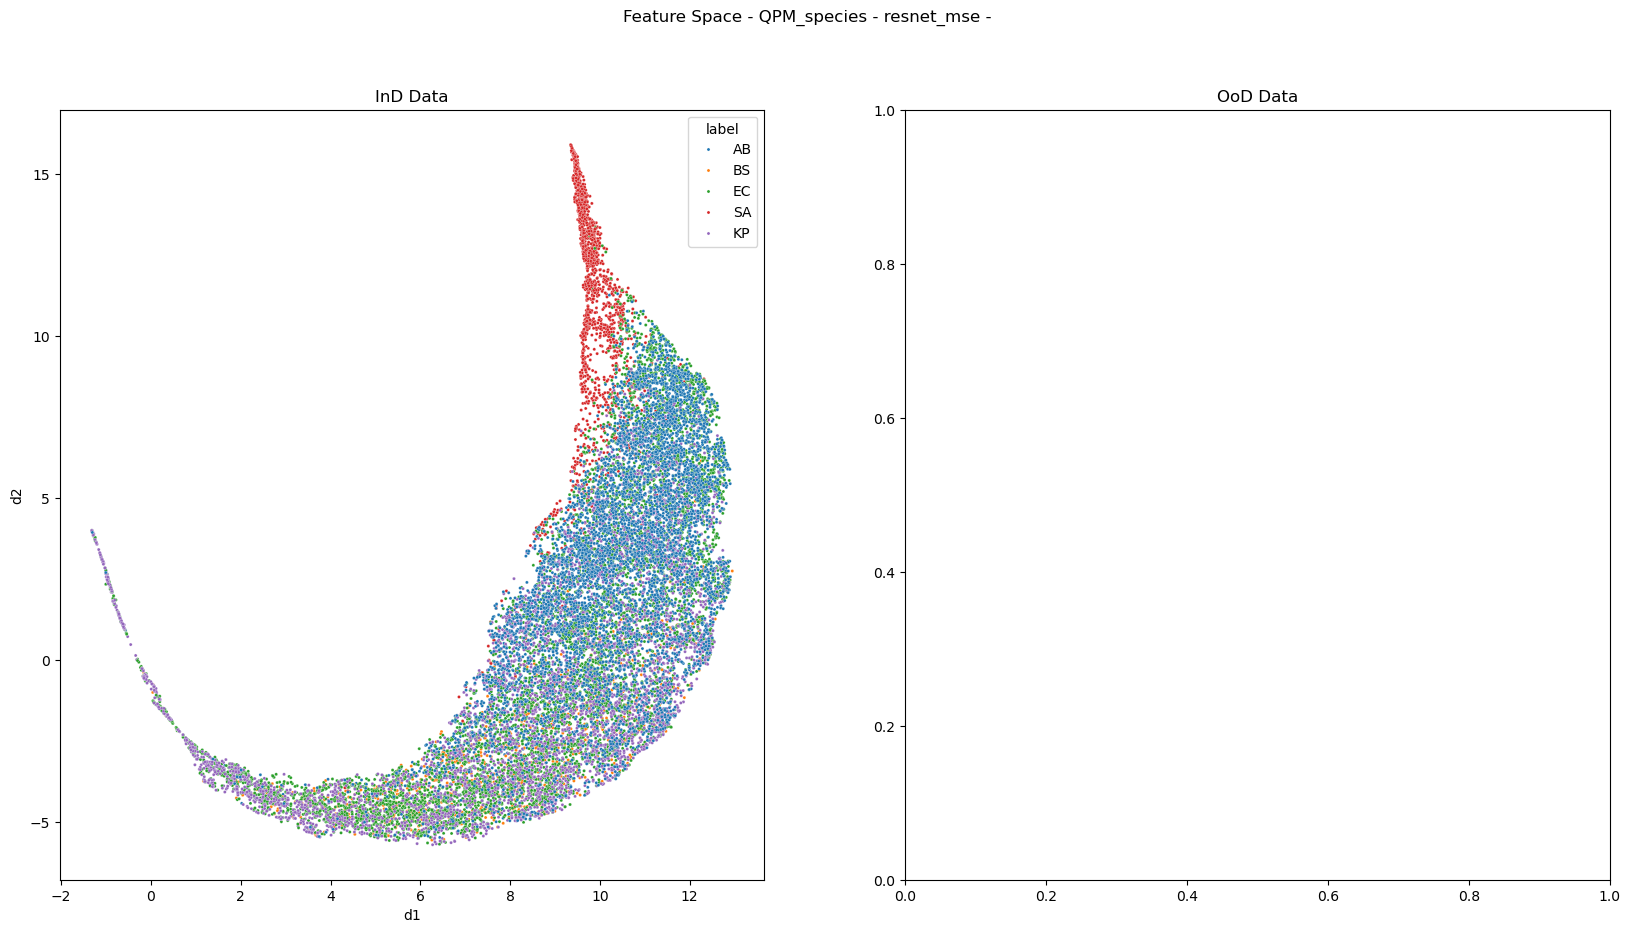

In [12]:
# plot feature space
df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

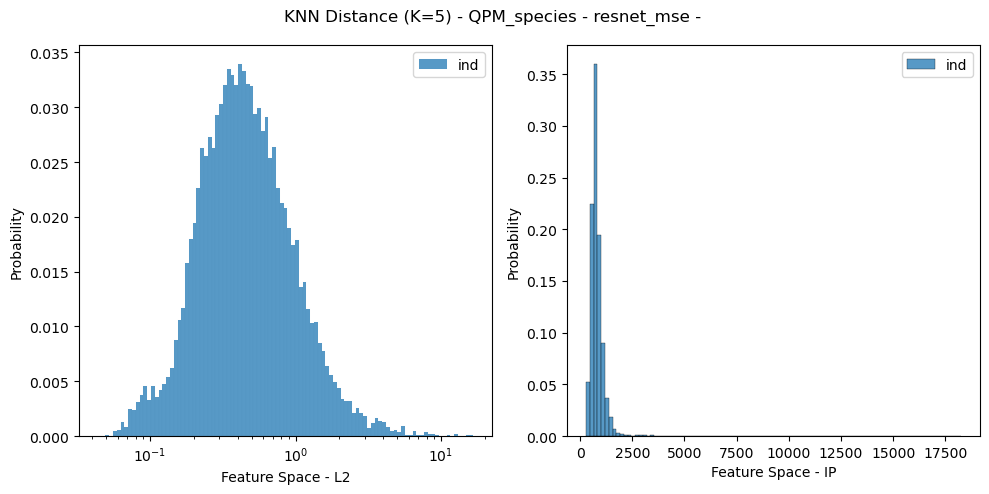

In [13]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
plt.tight_layout()
plt.show()

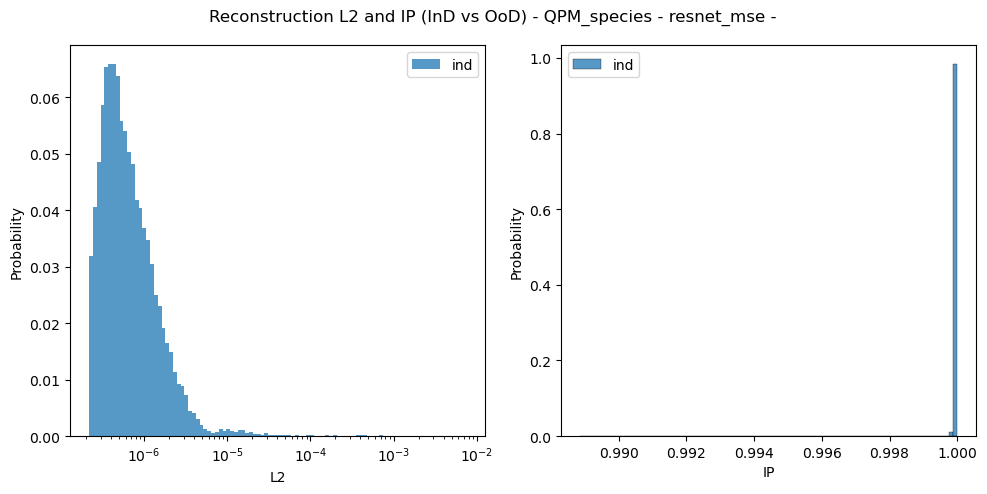

In [14]:
# plot reconstruction error of ind and ood data
def plot_rcn(val_rcn, ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=val_rcn.tolist(), ind_data=ind_rcn.tolist(), ood_data=ood_rcn.tolist()))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)

# training data
_val_inp, _val_rcn = flatten(val_inp), flatten(val_rcn)
_val_inp_unit, _val_rcn_unit = unit(_val_inp), unit(_val_rcn)
# metrics
val_rcn_l2 = ((_val_inp - _val_rcn) ** 2).mean(-1)
val_rcn_ip = (_val_inp_unit * _val_rcn_unit).sum(-1)

# ind test data
_ind_inp, _ind_rcn = flatten(ind_inp), flatten(ind_rcn)
_ind_inp_unit, _ind_rcn_unit = unit(_ind_inp), unit(_ind_rcn)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # ood test data
    _ood_inp, _ood_rcn = flatten(ood_inp), flatten(ood_rcn)
    _ood_inp_unit, _ood_rcn_unit = unit(_ood_inp), unit(_ood_rcn)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
run_stats["rcn_l2"] = plot_rcn(val_rcn_l2, ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(val_rcn_ip, ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))
import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)